In [1]:
import foldable_robotics.dxf as frd
import foldable_robotics as fr
import foldable_robotics.manufacturing as frm
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics.parts.castellated_hinge2 as frc
import shapely.geometry as sg

In [2]:
fr.display_height=300
fr.resolution = 4

In [3]:
desired_degrees = 120
thickness = 1
plain_width = frm.plain_hinge_width(desired_degrees,thickness)
plain_width

1.7320508075688774

In [4]:
support_width = 2 # must be larger than hinge width
kerf = .05
is_adhesive = [False,True,False,True,False]
arc_approx = 10
NUM_LAYERS = 5
bridge_thickness = 2
bounding_box_padding = 10
jig_spacing = 10
jig_dia = 5

In [7]:
body_vertices = frd.read_lwpolylines(r'C:\Users\hh021\Downloads\five_bar.dxf',layer='body',arc_approx = arc_approx)
body_vertices

[[[130.0, 90.0], [160.0, 160.0], [230.0, 140.0], [240.0, 80.0], [180.0, 50.0]]]

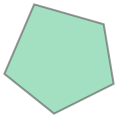

In [9]:
body_polygons = [sg.Polygon(item) for item in body_vertices]
body_polygons[0]

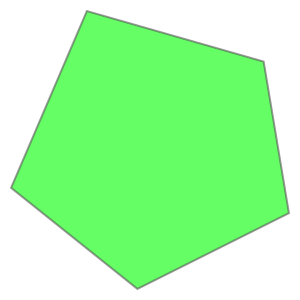

In [10]:
body_layer = Layer(*body_polygons)
body_layer

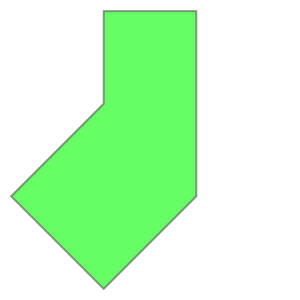

In [12]:
hole_vertices = frd.read_lwpolylines(r'C:\Users\hh021\Downloads\five_bar.dxf',layer='holes',arc_approx = arc_approx)
hole_layer = Layer(*[sg.Polygon(item) for item in hole_vertices])
hole_layer

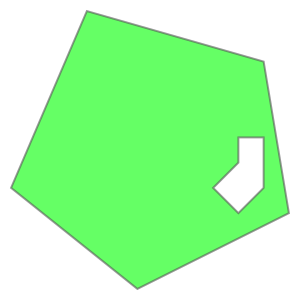

In [13]:
body_layer -= hole_layer
body_layer

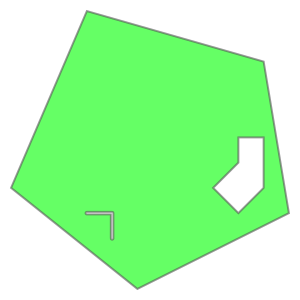

In [15]:
cut_vertices = frd.read_lwpolylines(r'C:\Users\hh021\Downloads\five_bar.dxf',
layer='cuts',
arc_approx = arc_approx)
cut_layer = Layer(*[sg.LineString(item) for item in cut_vertices])
cut_layer
cut_layer <<=.5
cut_layer
body_layer -= cut_layer
body_layer

In [17]:
joint_vertices = frd.read_lines(r'C:\Users\hh021\Downloads\five_bar.dxf', layer='joints')
joint_vertices

[[[190.0, 100.0], [130.0, 90.0]],
 [[190.0, 100.0], [160.0, 160.0]],
 [[190.0, 100.0], [240.0, 80.0]],
 [[190.0, 100.0], [180.0, 50.0]],
 [[190.0, 100.0], [230.0, 150.0]]]

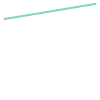

In [18]:
l = sg.LineString(joint_vertices[0])
l

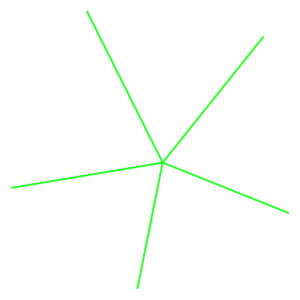

In [19]:
joint_lines_original_layer = Layer(*[sg.LineString(item) for item in joint_vertices])
joint_lines_original_layer

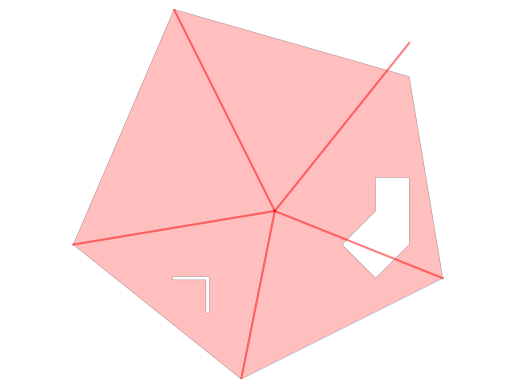

In [21]:
body_layer.plot()
joint_lines_original_layer.plot()

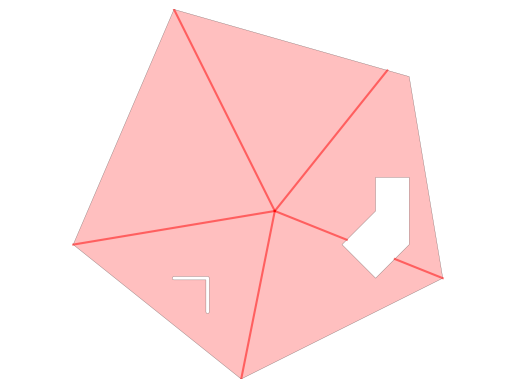

In [23]:
joint_lines_modified_layer = joint_lines_original_layer & body_layer
body_layer.plot()
joint_lines_modified_layer.plot()

In [24]:
modified_joint_vertices = [list(item.coords) for item in joint_lines_modified_layer.geoms]
modified_joint_vertices

[[(190.0, 100.0), (130.0, 90.0)],
 [(190.0, 100.0), (160.0, 160.0)],
 [(190.0, 100.0), (211.42857142857142, 91.42857142857143)],
 [(225.71428571428572, 85.71428571428571), (240.0, 80.0)],
 [(190.0, 100.0), (180.0, 50.0)],
 [(190.0, 100.0), (223.48837209302326, 141.86046511627907)]]

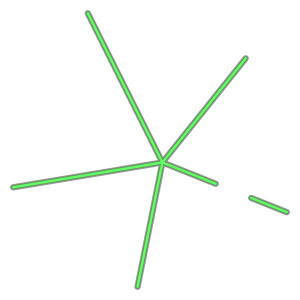

In [25]:
simple_joint_layer = joint_lines_modified_layer << plain_width/2
simple_joint_layer

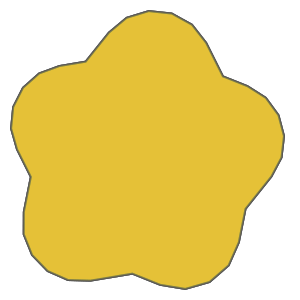

<Figure size 640x480 with 0 Axes>

In [26]:
hole,dummy = frm.calc_hole(modified_joint_vertices,plain_width/2)
fr.my_line_width=0
holes = hole.to_laminate(NUM_LAYERS)
holes<<=.5 # add a little extra material to ensure we removed enough.
holes

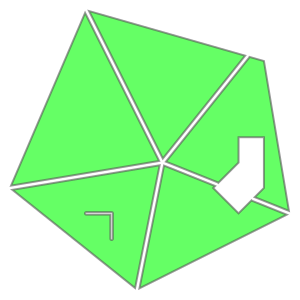

In [28]:
rigid_layer = (body_layer - simple_joint_layer)
rigid_layer

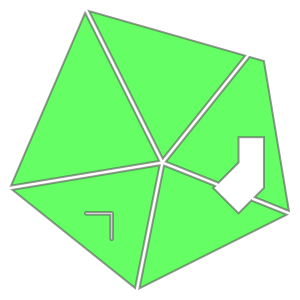

In [30]:
adhesive_layer = rigid_layer & body_layer
adhesive_layer

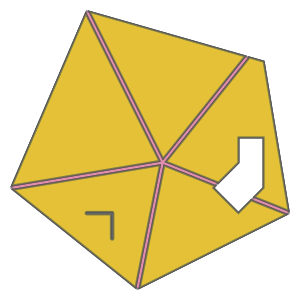

In [31]:
ideal_final_device = Laminate(rigid_layer,adhesive_layer, body_layer,
adhesive_layer,rigid_layer)
ideal_final_device

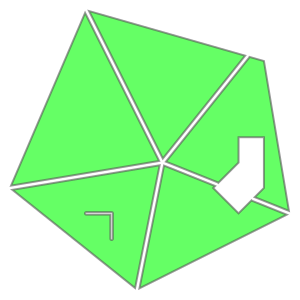

In [32]:
ideal_final_device[0]

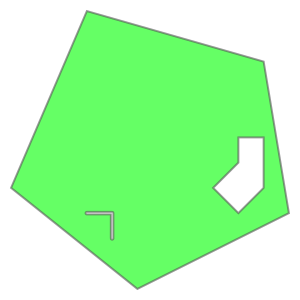

In [33]:
ideal_final_device[2]

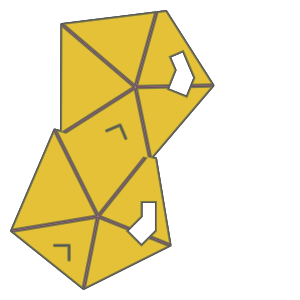

In [34]:
ideal_final_device | ideal_final_device.rotate(23).translate(80,23)

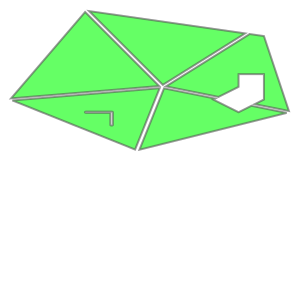

In [35]:
ideal_final_device[0].scale(2,1)

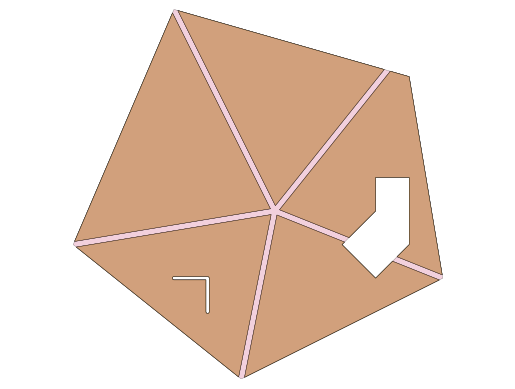

In [71]:

scaled_device = ideal_final_device.scale(0.5, 0.5)  
scaled_device.plot()


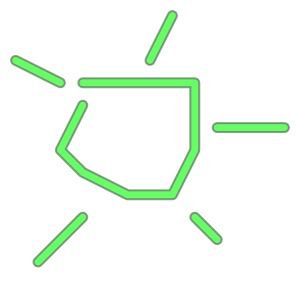

In [37]:
bridges = frd.read_lines(r'C:\Users\hh021\Downloads\five_bar.dxf', layer='bridge')
bridges
bridges_layer = Layer(*[sg.LineString(item) for item in bridges])
bridges_layer <<= bridge_thickness
bridges_layer

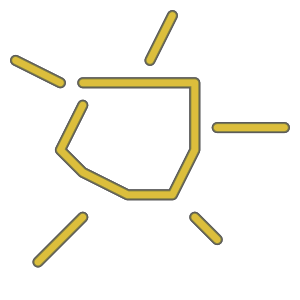

In [38]:
bridges_lam = Laminate(bridges_layer,bridges_layer,Layer(),bridges_layer,bridges_layer)
bridges_lam

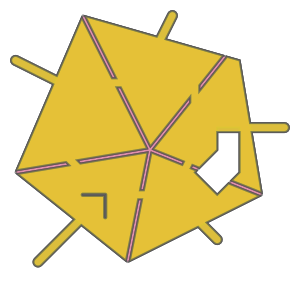

In [39]:
supported_actual_device = ideal_final_device | bridges_lam
supported_actual_device

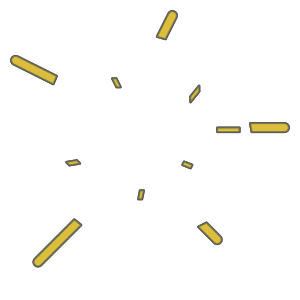

In [40]:
diff = supported_actual_device - ideal_final_device
removal = frm.cleanup(diff, .1)
removal

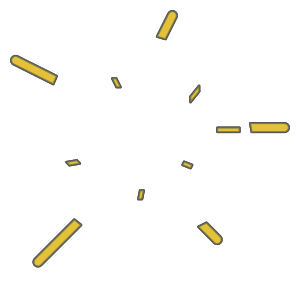

In [42]:
removal = frm.keepout_laser(removal)
removal

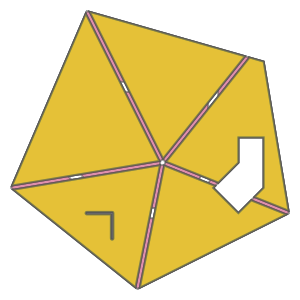

In [43]:
actual_final_device = ideal_final_device- holes - removal
actual_final_device

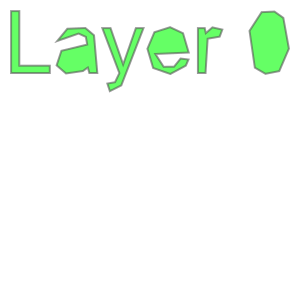

In [44]:
keepout = frm.keepout_laser(actual_final_device)
keepout
layer_id = frm.build_layer_numbers(NUM_LAYERS,text_size=jig_dia)
layer_id = layer_id.simplify(.2)
layer_id[0]

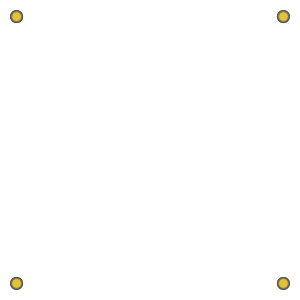

In [45]:
(x1,y1),(x2,y2) = actual_final_device.bounding_box_coords()
w1,h1 = actual_final_device.get_dimensions()
w2 = round(w1/jig_spacing)*jig_spacing+jig_spacing+support_width
h2 = round(h1/jig_spacing)*jig_spacing+jig_spacing+support_width
x1 -= (w2-w1)/2
y1 -= (h2-h1)/2
x2 += (w2-w1)/2
y2 += (h2-h1)/2
points = []
points.append(sg.Point(x1,y1))
points.append(sg.Point(x2,y1))
points.append(sg.Point(x1,y2))
points.append(sg.Point(x2,y2))
alignment_holes_layer = Layer(*points)
alignment_holes_layer<<=(jig_dia/2)
alignment_holes=alignment_holes_layer.to_laminate(NUM_LAYERS)
alignment_holes

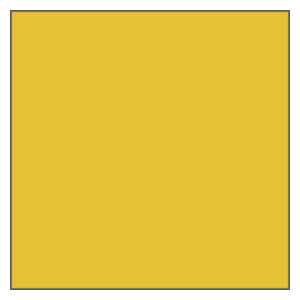

In [46]:
sheet_layer = (alignment_holes_layer<<bounding_box_padding).bounding_box()
sheet=sheet_layer.to_laminate(NUM_LAYERS)
sheet

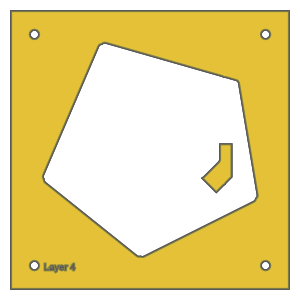

In [47]:
removable_scrap = frm.calculate_removable_scrap(
actual_final_device,sheet,support_width,is_adhesive)
web = removable_scrap-alignment_holes-layer_id.translate(x1+jig_dia,y1-jig_dia/2)
web

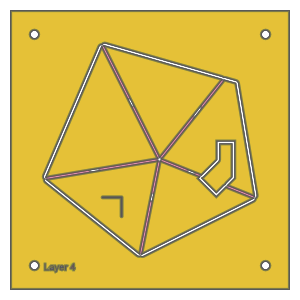

In [48]:
(web|actual_final_device)

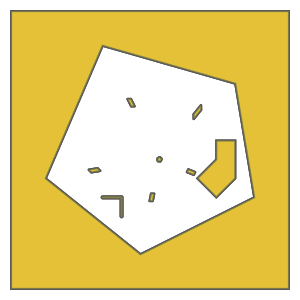

In [49]:
second_pass_scrap = sheet-keepout
second_pass_scrap

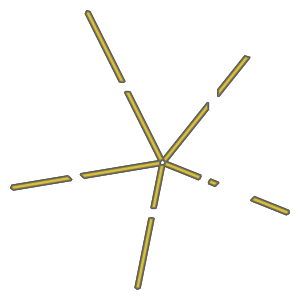

In [51]:
first_pass_scrap = sheet - second_pass_scrap - actual_final_device
first_pass_scrap = frm.cleanup(first_pass_scrap,.00001)
first_pass_scrap

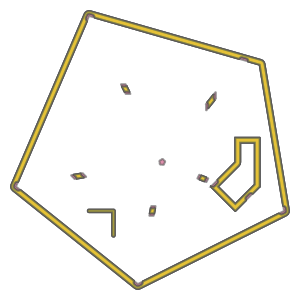

In [54]:
support = frm.support(actual_final_device,
frm.keepout_laser,support_width,support_width/2)
support

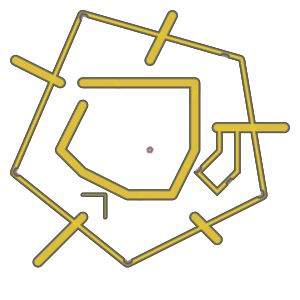

In [55]:
support | bridges_lam

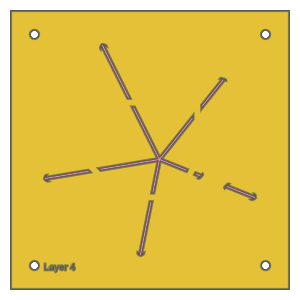

In [56]:
supported_design = web|actual_final_device|support| bridges_lam
supported_design

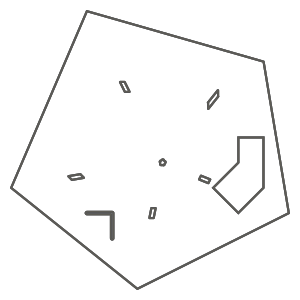

In [57]:
cut_material = (keepout<<kerf)-keepout
cut_material

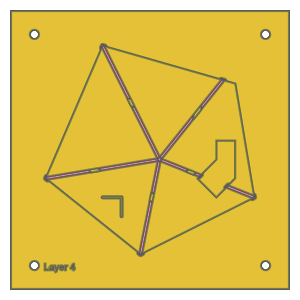

In [58]:
remaining_material = supported_design-cut_material
remaining_material

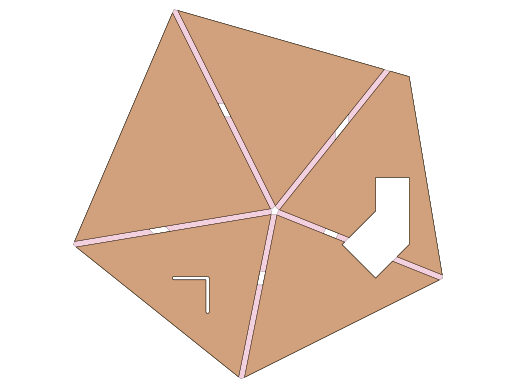

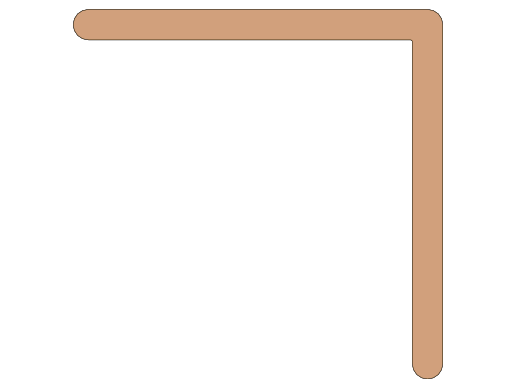

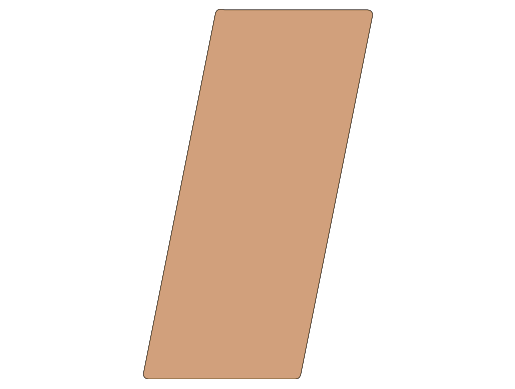

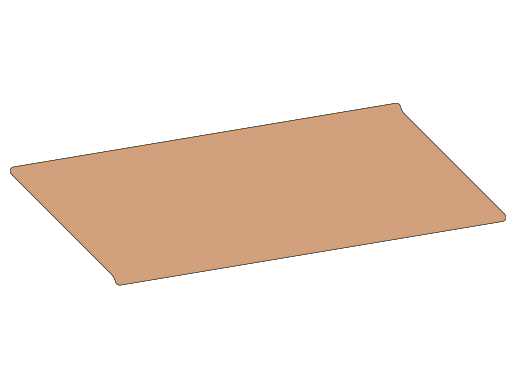

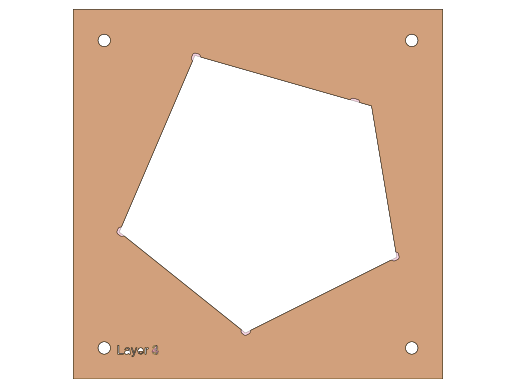

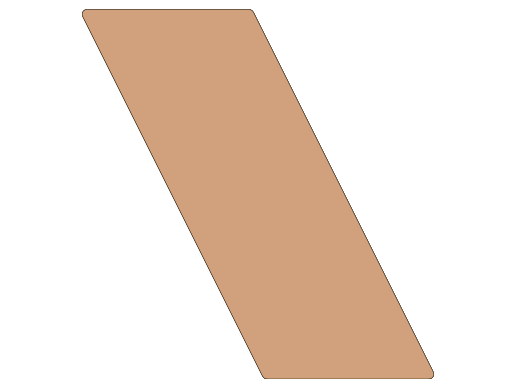

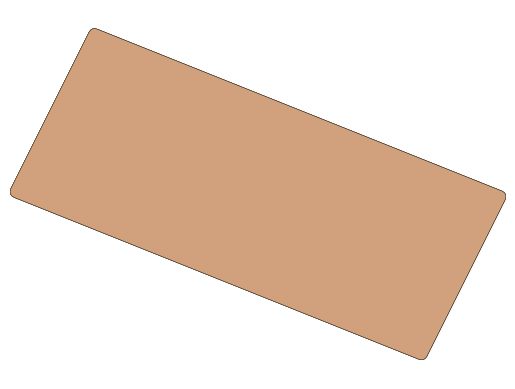

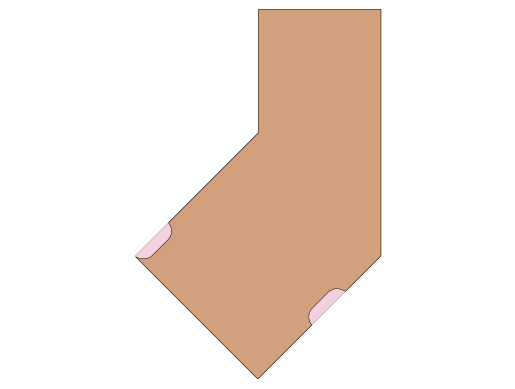

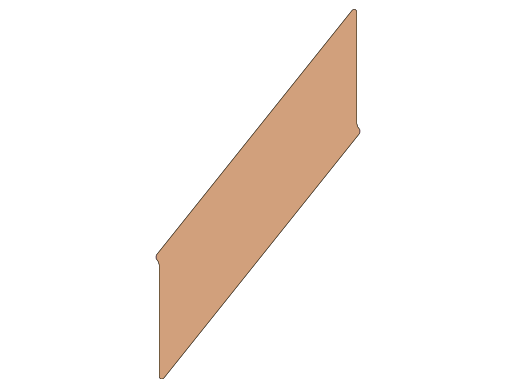

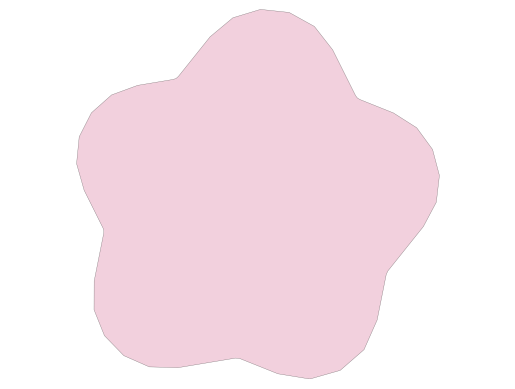

In [60]:
remaining_parts = frm.find_connected(remaining_material,is_adhesive)
for item in remaining_parts:
    item.plot(new=True)

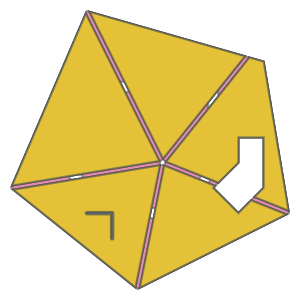

In [63]:
test_part=actual_final_device>>1
for result in remaining_parts:
    if not (result&test_part).is_null():
        break
result

In [64]:
check = (result^actual_final_device)
check>>=1e-1
assert(check.is_null())

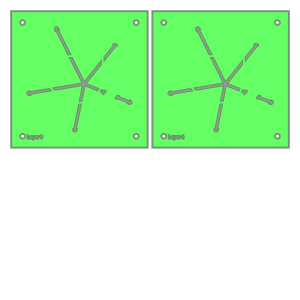

In [65]:
w,h = supported_design.get_dimensions()
p0,p1 = supported_design.bounding_box_coords()
rigid_layer = supported_design[0] | (supported_design[-1].translate(w+5,0))
rigid_layer

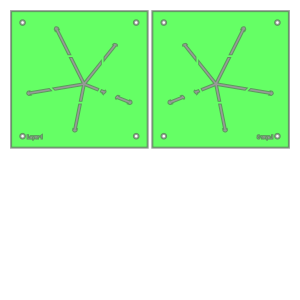

In [66]:
l4 = supported_design[3].scale(-1,1)
p2,p3 = l4.bounding_box_coords()
l4 = l4.translate(p0[0]-p2[0]+w+5,p0[1]-p2[1])
adhesive_layer = supported_design[1] | l4
adhesive_layer

In [67]:
first_pass = Laminate(rigid_layer,adhesive_layer,supported_design[2])
first_pass.export_dxf('first_pass')

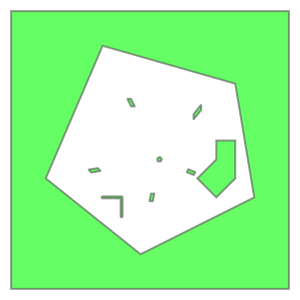

In [68]:
final_cut = sheet - keepout
final_cut = final_cut[0]
final_cut.export_dxf('final_cut')
final_cut


DISCUSSION

1.Changes Made to Generate Cut-Files
To adapt the tutorial, I ensured my .dxf file followed the same layer structure (body, holes, cuts, joints, etc.). I adjusted the kerf to match my material and refined hinge and hole sizes for proper alignment. I also added alignment holes, padding, and scaled the geometry as instructed. Lastly, I enhanced the script to check for errors after scaling and to handle any overlaps or mismatched geometries.




















2.Scale Invariant vs. Scale Dependent Variables


Scale Invariant:



Kerf (related to the laser cutting process).
Material thickness and number of layers.
Adhesive layer configuration (determined by design intent, not size).



Scale Dependent:

Part dimensions, including body, hole positions, and joint lengths.
Bounding box size and padding (proportional to the design).
Bridge dimensions and spacing (these need resizing to maintain functionality).

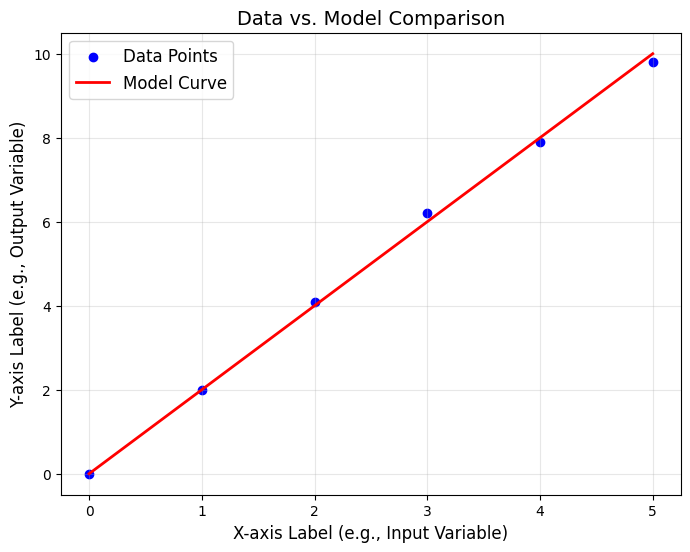

In [69]:
import numpy as np
import matplotlib.pyplot as plt


data_x = np.array([0, 1, 2, 3, 4, 5])
data_y = np.array([0, 2, 4.1, 6.2, 7.9, 9.8])  


model_x = np.linspace(0, 5, 100)  
model_y = 2 * model_x  


plt.figure(figsize=(8, 6))
plt.scatter(data_x, data_y, color='blue', label='Data Points', marker='o')  
plt.plot(model_x, model_y, color='red', label='Model Curve', linewidth=2)   


plt.title("Data vs. Model Comparison", fontsize=14)
plt.xlabel("X-axis Label (e.g., Input Variable)", fontsize=12)
plt.ylabel("Y-axis Label (e.g., Output Variable)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)


plt.savefig("data_model_comparison.png", dpi=300)  
plt.show()
